In [16]:
# Load data frame from cloudant/ ApacheCouchDB

import ibmos2spark

# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'api_key': 'PUJMZf9PLqN4y-6NUtVlEuq6zFoWhfuecFVMYLBrkxrT',
    'service_id': 'iam-ServiceId-9cd8e66e-3bb4-495a-807a-588692cca4d0',
    'iam_service_endpoint': 'https://iam.bluemix.net/oidc/token'}

configuration_name = 'os_b0f1407510994fd1b793b85137baafb8_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

df = spark.read.parquet(cos.url('washing.parquet', 'courseradsnew-donotdelete-pr-1hffrnl2pprwut'))
df.createOrReplaceTempView('washing')
df.show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

In [17]:
# Check how many rows we get
df.count()

2058

In [18]:
# register the data frame in the ApacheSparkSQL catalog so that we can query it using SQL
df.createOrReplaceTempView("washing")
spark.sql("SELECT * FROM washing").show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

In [4]:
# create a python list and visualize voltage using a box plot to get an idea on the value distribution of this parameter.  
result = spark.sql("select voltage from washing where voltage is not null")
result_array = result.rdd.map(lambda row : row.voltage).sample(False,0.1).collect()

#just print the 1st 15 elements
result_array[:15]

[225, 227, 233, 239, 232, 220, 223, 222, 228, 232, 230, 225, 236, 234, 244]

In [19]:
# activate the notebook to show the plots directly under the cell
%matplotlib inline

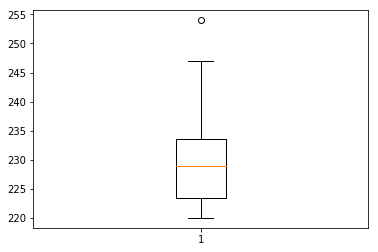

In [6]:
import matplotlib.pyplot as plt
plt.boxplot(result_array)
plt.show()

In [20]:
# add time series data and plot time dimension as horizontal x-axis
result = spark.sql("select voltage,ts from washing where voltage is not null order by ts asc")
result_rdd = result.rdd.sample(False,0.1).map(lambda row : (row.ts,row.voltage))
result_array_ts = result_rdd.map(lambda ts_voltage: ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage: ts_voltage[1]).collect()
print(result_array_ts[:15])
print(result_array_voltage[:15])

[1547808734922, 1547808761934, 1547808764937, 1547808776948, 1547808791957, 1547808806965, 1547808812970, 1547808830981, 1547808957136, 1547808978152, 1547809017198, 1547809026203, 1547809071226, 1547809092245, 1547809095246]
[234, 230, 221, 235, 238, 221, 227, 227, 221, 228, 250, 221, 231, 227, 237]


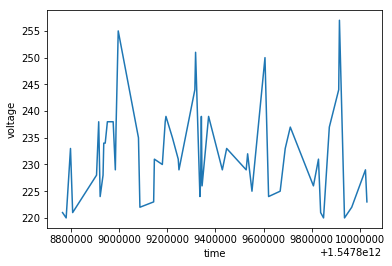

In [8]:
plt.plot(result_array_ts,result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

In [9]:
# find out in which date range we have data available
spark.sql("select min(ts),max(ts) from washing").show()

+-------------+-------------+
|      min(ts)|      max(ts)|
+-------------+-------------+
|1547808720911|1547810064867|
+-------------+-------------+



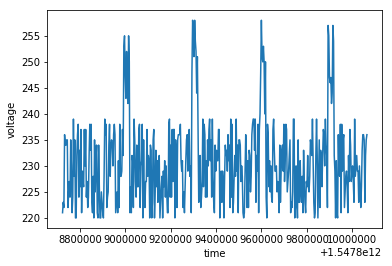

In [10]:
# select the data of an interval of 60 minutes and plot

result = spark.sql(
"""
select voltage,ts from washing 
    where voltage is not null and 
    ts > 1547808720911 and
    ts <= 1547810064867+3600000
    order by ts asc
""")
result_rdd = result.rdd.map(lambda row : (row.ts,row.voltage))
result_array_ts = result_rdd.map(lambda ts_voltage: ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage: ts_voltage[1]).collect()
plt.plot(result_array_ts,result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

As you can see we are not only able to spot the outliers but also see a time pattern of these outliers occuring which can be used for further downstream analysis. Again your brain was already capable of spotting the pattern. In the next two coursera courses we will teach a machine to spot those patterns as well.

Now we've plotted a maximum of two dimensions at a time, let's go for three in a so-called 3D scatter plot. Again we have to create python lists (with applied sampling if necessary) from three properties of our data.

In [11]:
# create python lists and 3D scallter plot

result_df = spark.sql("""
select hardness,temperature,flowrate from washing
    where hardness is not null and 
    temperature is not null and 
    flowrate is not null
""")
result_rdd = result_df.rdd.sample(False,0.1).map(lambda row : (row.hardness,row.temperature,row.temperature))
result_array_hardness = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[0]).collect()
result_array_temperature = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[1]).collect()
result_array_flowrate = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[2]).collect()

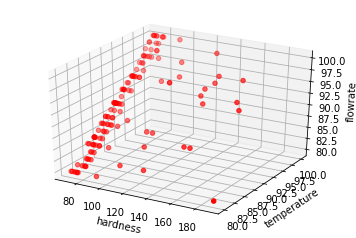

In [12]:
# import library and create a 3D scatter plot

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(result_array_hardness,result_array_temperature,result_array_flowrate, c='r', marker='o')

ax.set_xlabel('hardness')
ax.set_ylabel('temperature')
ax.set_zlabel('flowrate')

plt.show()

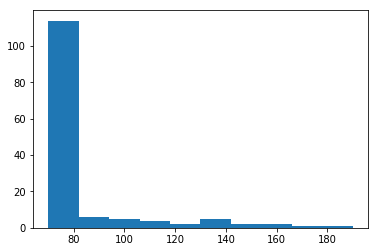

In [13]:
# create a histogram to double-check what's going on with hardness since it seems that it really sticks around 60-80 and very seldom creates values above that
plt.hist(result_array_hardness)
plt.show()

In [ ]:
# based on the histgram we created above we can say that Our assumpion was correct, nearly all values are around 60-80 with very less values about that threshold. 